# Import Libraries

In [ ]:
#!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import calendar

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV


from sklearn.model_selection import *
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Helper Functions

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.
    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri
    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.25 , q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


# Exploratory Data Analysis (EDA)

In [ ]:
df = pd.read_csv("/content/thyTrain.csv")
check_df(df)

##################### Shape #####################
(181173, 17)
##################### Types #####################
CARRIER              object
AIRCRAFT_TYPE        object
OND_SELL_CLASS       object
LEG1_SELL_CLASS      object
OND_CABIN_CLASS      object
LEG1_CABIN_CLASS     object
HUB                  object
DETUR_FACTOR        float64
CONNECTION_TIME       int64
PSGR_COUNT            int64
LEG1_DEP_FULL        object
LEG1_ARR_FULL        object
LEG2_DEP_FULL        object
LEG2_ARR_FULL        object
LEG1_DURATION        object
LEG2_DURATION        object
FLIGHT_DURATION      object
dtype: object
##################### Head #####################
  CARRIER AIRCRAFT_TYPE OND_SELL_CLASS LEG1_SELL_CLASS OND_CABIN_CLASS  \
0      3K           77W              T               T               Q   
1      SV           330              T               T               Q   
2      SK           73W              T               T               Q   
3      SN           319              L              

<ipython-input-97-5324642f1bf4>:13: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [ ]:
df["PSGR_COUNT"].describe().T

count    181173.000000
mean          2.124936
std           3.066907
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         190.000000
Name: PSGR_COUNT, dtype: float64

In [ ]:
df["PSGR_COUNT"].sort_values(ascending= False).head(10)

52202     190
15850     153
101215    143
50544     141
27634     138
87194     119
12853     115
68182     111
140720    111
144697    109
Name: PSGR_COUNT, dtype: int64

In [ ]:
LEG_LISTS = ["LEG1_DEP_FULL", "LEG1_ARR_FULL", "LEG2_DEP_FULL", "LEG2_ARR_FULL"]

for i in LEG_LISTS:
    print(i + " max= "+df[i].max() +" min= "+df[i].min())

LEG1_DEP_FULL max= 2018-12-31 23:45:00 min= 2018-01-01 00:00:00
LEG1_ARR_FULL max= 2019-01-01 10:35:00 min= 2018-01-01 00:50:00
LEG2_DEP_FULL max= 2019-01-02 00:15:00 min= 2018-01-01 01:15:00
LEG2_ARR_FULL max= 2019-01-02 11:25:00 min= 2018-01-01 04:45:00


# Missing Values

In [ ]:
df.isnull().sum()

CARRIER               0
AIRCRAFT_TYPE       716
OND_SELL_CLASS        0
LEG1_SELL_CLASS       0
OND_CABIN_CLASS       0
LEG1_CABIN_CLASS      0
HUB                   0
DETUR_FACTOR          0
CONNECTION_TIME       0
PSGR_COUNT            0
LEG1_DEP_FULL         0
LEG1_ARR_FULL         0
LEG2_DEP_FULL         0
LEG2_ARR_FULL         0
LEG1_DURATION         0
LEG2_DURATION         0
FLIGHT_DURATION       0
dtype: int64

In [ ]:
df["AIRCRAFT_TYPE"].fillna(df["AIRCRAFT_TYPE"].mode()[0], inplace=True)

# Feature Extraction

In [ ]:
df["LEG1_DEP_FULL"] = pd.to_datetime(df["LEG1_DEP_FULL"])
df["LEG1_ARR_FULL"] = pd.to_datetime(df["LEG1_ARR_FULL"])
df["LEG2_DEP_FULL"] = pd.to_datetime(df["LEG2_DEP_FULL"])
df["LEG2_ARR_FULL"] = pd.to_datetime(df["LEG2_ARR_FULL"])

df["LEG1_DEP_MONTH"] = df["LEG1_DEP_FULL"].dt.month
df["LEG1_DEP_HOUR"] = df["LEG1_DEP_FULL"].dt.hour

df["LEG1_ARR_MONTH"] = df["LEG1_ARR_FULL"].dt.month
df["LEG1_ARR_HOUR"] = df["LEG1_ARR_FULL"].dt.hour

df["LEG2_DEP_MONTH"] = df["LEG2_DEP_FULL"].dt.month
df["LEG2_DEP_HOUR"] = df["LEG2_DEP_FULL"].dt.hour

df["LEG2_ARR_MONTH"] = df["LEG2_ARR_FULL"].dt.month
df["LEG2_ARR_HOUR"] = df["LEG2_ARR_FULL"].dt.hour

df["LEG1_DEP_DAY"] = df["LEG1_DEP_FULL"].apply(lambda x: calendar.day_name[x.weekday()])
df["LEG1_ARR_DAY"] = df["LEG1_ARR_FULL"].apply(lambda x: calendar.day_name[x.weekday()])
df["LEG2_DEP_DAY"] = df["LEG2_DEP_FULL"].apply(lambda x: calendar.day_name[x.weekday()])
df["LEG2_ARR_DAY"] = df["LEG2_ARR_FULL"].apply(lambda x: calendar.day_name[x.weekday()])

df["LEG1_DURATION"] = pd.to_timedelta(df["LEG1_DURATION"])
df["LEG2_DURATION"] = pd.to_timedelta(df["LEG2_DURATION"])
df["FLIGHT_DURATION"] = pd.to_timedelta(df["FLIGHT_DURATION"])


df["LEG1_DURATION_MINUTES"] = df["LEG1_DURATION"].apply(lambda x: x.seconds / 60)
df["LEG2_DURATION_MINUTES"] = df["LEG2_DURATION"].apply(lambda x: x.seconds / 60)
df["FLIGHT_DURATION_MINUTES"] = df["FLIGHT_DURATION"].apply(lambda x: x.seconds / 60)

df["FLIGHT_DURATION_MINUTES_FLIGHTS"] = df["LEG1_DURATION_MINUTES"] + df["LEG2_DURATION_MINUTES"]

df["CONNECTION_RATIO"] = df["FLIGHT_DURATION_MINUTES_FLIGHTS"] / df["FLIGHT_DURATION_MINUTES"]

df["LEG1_RATIO"] = df["LEG1_DURATION_MINUTES"] / df["FLIGHT_DURATION_MINUTES"]
df["LEG2_RATIO"] = df["LEG2_DURATION_MINUTES"] / df["FLIGHT_DURATION_MINUTES"]

In [ ]:
df.drop(["LEG1_DEP_FULL", "LEG1_ARR_FULL", "LEG2_DEP_FULL", "LEG2_ARR_FULL", "LEG1_DURATION", "LEG2_DURATION",
             "FLIGHT_DURATION"], axis=1, inplace=True)

## Separating categorical and numeric variables

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)


In [ ]:
num_cols = [col for col in num_cols if "PSGR_COUNT" not in col]

# Outlier Values

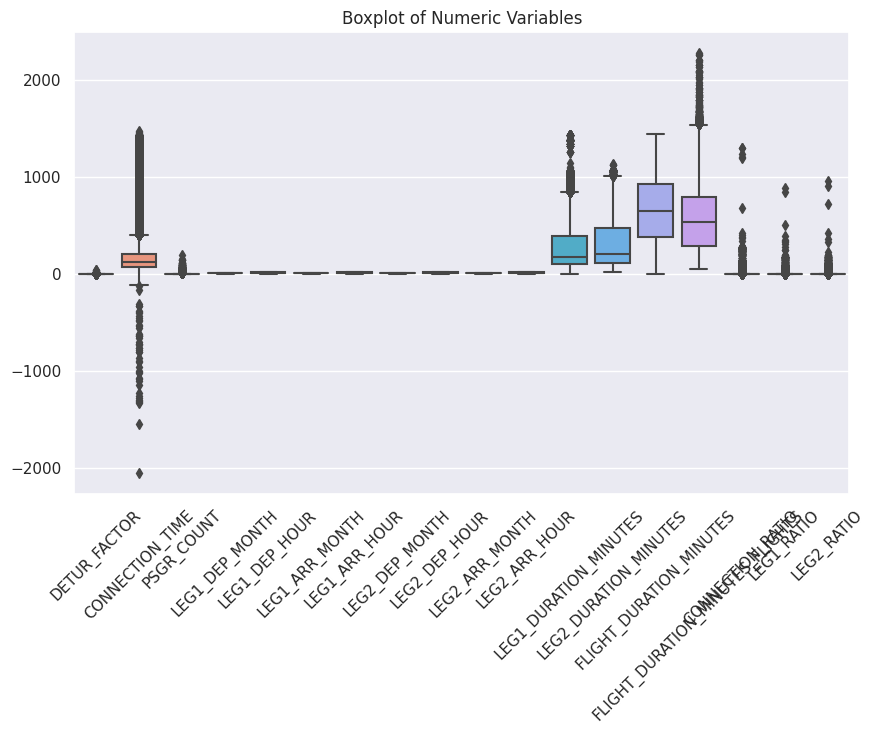

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot of Numeric Variables')
plt.xticks(rotation=45)
plt.show()

In [ ]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DETUR_FACTOR,181173.0,1.127520,0.144565,0.991821,1.015367,1.066309,1.189913,1.451732
CONNECTION_TIME,181173.0,151.260875,109.181076,-126.500000,70.000000,120.000000,201.000000,397.500000
PSGR_COUNT,181173.0,2.124936,3.066907,1.000000,1.000000,1.000000,2.000000,190.000000
LEG1_DEP_MONTH,181173.0,6.604632,3.370222,1.000000,4.000000,7.000000,9.000000,12.000000
LEG1_DEP_HOUR,181173.0,11.920689,6.546270,0.000000,7.000000,12.000000,17.000000,23.000000
LEG1_ARR_MONTH,181173.0,6.606310,3.370438,1.000000,4.000000,7.000000,9.000000,12.000000
LEG1_ARR_HOUR,181173.0,11.769149,6.488155,0.000000,6.000000,12.000000,17.000000,23.000000
LEG2_DEP_MONTH,181173.0,6.607077,3.370570,1.000000,4.000000,7.000000,9.000000,12.000000
LEG2_DEP_HOUR,181173.0,12.270791,6.592820,0.000000,7.000000,13.000000,18.000000,23.000000
LEG2_ARR_MONTH,181173.0,6.607922,3.371204,1.000000,4.000000,7.000000,9.000000,12.000000


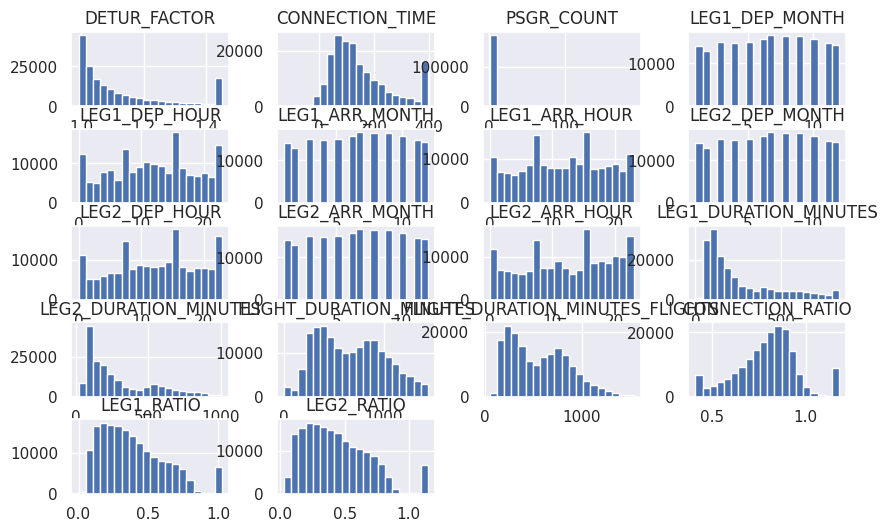

In [ ]:
df.hist(bins=20, figsize=(10, 6))
plt.title('Histogram Plot of Numeric Variables')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()



# Rare Encoding





In [ ]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df



df = rare_encoder(df, 0.05)
df


,CARRIER,AIRCRAFT_TYPE,OND_SELL_CLASS,LEG1_SELL_CLASS,OND_CABIN_CLASS,LEG1_CABIN_CLASS,HUB,DETUR_FACTOR,CONNECTION_TIME,PSGR_COUNT,...,LEG1_ARR_DAY,LEG2_DEP_DAY,LEG2_ARR_DAY,LEG1_DURATION_MINUTES,LEG2_DURATION_MINUTES,FLIGHT_DURATION_MINUTES,FLIGHT_DURATION_MINUTES_FLIGHTS,CONNECTION_RATIO,LEG1_RATIO,LEG2_RATIO
0,3K,77W,T,T,Q,Q,DXB,1.000041,200.0,1,...,Tuesday,Tuesday,Wednesday,110.0,295.0,605.0,405.0,0.669421,0.181818,0.487603
1,Rare,Rare,T,T,Q,Q,Rare,1.043824,120.0,1,...,Sunday,Monday,Monday,105.0,520.0,745.0,625.0,0.838926,0.140940,0.697987
2,Rare,Rare,T,T,Q,Q,Rare,1.022142,45.0,1,...,Monday,Monday,Monday,50.0,115.0,210.0,165.0,0.785714,0.238095,0.547619
3,Rare,319,L,L,Q,Q,Rare,1.442927,140.0,1,...,Tuesday,Tuesday,Tuesday,105.0,370.0,615.0,475.0,0.772358,0.170732,0.601626
4,3K,Rare,K,K,Q,Y,Rare,1.282117,265.0,1,...,Sunday,Sunday,Sunday,80.0,390.0,735.0,470.0,0.639456,0.108844,0.530612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181168,Rare,Rare,Q,Q,Q,Q,Rare,1.000338,127.0,1,...,Sunday,Sunday,Sunday,214.0,119.0,460.0,333.0,0.723913,0.465217,0.258696
181169,DL,Rare,Rare,Rare,Q,Q,Rare,1.172753,57.0,2,...,Monday,Monday,Tuesday,98.0,214.0,369.0,312.0,0.845528,0.265583,0.579946
181170,Rare,Rare,Q,Q,Q,Q,Rare,1.148413,100.0,4,...,Saturday,Saturday,Saturday,130.0,130.0,360.0,260.0,0.722222,0.361111,0.361111
181171,U8,Rare,Q,Q,Q,Q,Rare,1.262967,251.0,1,...,Friday,Friday,Friday,140.0,77.0,468.0,217.0,0.463675,0.299145,0.164530


# One Hot Encoding

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


ohe_cols = [col for col in df.columns if (10 >= df[col].nunique() > 2) & (col != "PSGR_COUNT")]
df = one_hot_encoder(df, ohe_cols)
df

,DETUR_FACTOR,CONNECTION_TIME,PSGR_COUNT,LEG1_DEP_MONTH,LEG1_DEP_HOUR,LEG1_ARR_MONTH,LEG1_ARR_HOUR,LEG2_DEP_MONTH,LEG2_DEP_HOUR,LEG2_ARR_MONTH,...,LEG2_DEP_DAY_Thursday,LEG2_DEP_DAY_Tuesday,LEG2_DEP_DAY_Wednesday,LEG2_ARR_DAY_Friday,LEG2_ARR_DAY_Monday,LEG2_ARR_DAY_Saturday,LEG2_ARR_DAY_Sunday,LEG2_ARR_DAY_Thursday,LEG2_ARR_DAY_Tuesday,LEG2_ARR_DAY_Wednesday
0,1.000041,200.0,1,3.0,16,3.0,18.0,3.0,21.0,3.0,...,0,1,0,0,0,0,0,0,0,1
1,1.043824,120.0,1,2.0,21,2.0,23.0,2.0,1.0,2.0,...,0,0,0,0,1,0,0,0,0,0
2,1.022142,45.0,1,11.0,5,11.0,6.0,11.0,6.0,11.0,...,0,0,0,0,1,0,0,0,0,0
3,1.442927,140.0,1,9.0,4,9.0,6.0,9.0,8.0,9.0,...,0,1,0,0,0,0,0,0,1,0
4,1.282117,265.0,1,3.0,8,3.0,9.0,3.0,14.0,3.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181168,1.000338,127.0,1,7.0,11,7.0,14.0,7.0,16.0,7.0,...,0,0,0,0,0,0,1,0,0,0
181169,1.172753,57.0,2,10.0,20,10.0,22.0,10.0,23.0,10.0,...,0,0,0,0,0,0,0,0,1,0
181170,1.148413,100.0,4,4.0,17,4.0,19.0,4.0,21.0,4.0,...,0,0,0,0,0,1,0,0,0,0
181171,1.262967,251.0,1,4.0,13,4.0,15.0,4.0,19.0,4.0,...,0,0,0,1,0,0,0,0,0,0


# Scaling

In [ ]:
scaler = StandardScaler()

df[num_cols] = scaler.fit_transform(df[num_cols])
df

,DETUR_FACTOR,CONNECTION_TIME,PSGR_COUNT,LEG1_DEP_MONTH,LEG1_DEP_HOUR,LEG1_ARR_MONTH,LEG1_ARR_HOUR,LEG2_DEP_MONTH,LEG2_DEP_HOUR,LEG2_ARR_MONTH,...,LEG2_DEP_DAY_Thursday,LEG2_DEP_DAY_Tuesday,LEG2_DEP_DAY_Wednesday,LEG2_ARR_DAY_Friday,LEG2_ARR_DAY_Monday,LEG2_ARR_DAY_Saturday,LEG2_ARR_DAY_Sunday,LEG2_ARR_DAY_Thursday,LEG2_ARR_DAY_Tuesday,LEG2_ARR_DAY_Wednesday
0,-0.881809,0.446408,1,-1.069556,0.623152,-1.069985,0.960345,-1.070171,1.324051,-1.070220,...,0,1,0,0,0,0,0,0,0,1
1,-0.578948,-0.286322,1,-1.366273,1.386948,-1.366684,1.730982,-1.366858,-1.709560,-1.366851,...,0,0,0,0,1,0,0,0,0,0
2,-0.728933,-0.973256,1,1.304181,-1.057199,1.303600,-0.889184,1.303321,-0.951157,1.302825,...,0,0,0,0,1,0,0,0,0,0
3,2.181770,-0.103140,1,0.710747,-1.209958,0.710203,-0.889184,0.709948,-0.647796,0.709564,...,0,1,0,0,0,0,0,0,1,0
4,1.069399,1.041750,1,-1.069556,-0.598921,-1.069985,-0.426802,-1.070171,0.262287,-1.070220,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181168,-0.879753,-0.222208,1,0.117312,-0.140644,0.116807,0.343835,0.116575,0.565649,0.116302,...,0,0,0,0,0,0,1,0,0,0
181169,0.312894,-0.863347,2,1.007464,1.234189,1.006901,1.576855,1.006635,1.627413,1.006195,...,0,0,0,0,0,0,0,0,1,0
181170,0.144527,-0.469505,4,-0.772839,0.775911,-0.773287,1.114473,-0.773485,1.324051,-0.773590,...,0,0,0,0,0,1,0,0,0,0
181171,0.936930,0.913523,1,-0.772839,0.164875,-0.773287,0.497963,-0.773485,1.020690,-0.773590,...,0,0,0,1,0,0,0,0,0,0


# Modelling

In [ ]:
y = df["PSGR_COUNT"]
X = df.drop(["PSGR_COUNT"], axis=1)

In [ ]:
models = [ #("LR", LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          #("KNN", KNeighborsRegressor()),
          #("CART", DecisionTreeRegressor()),
          #("RF", RandomForestRegressor()),
          #("SVR", SVR()),
          #("GBM", GradientBoostingRegressor()),
          #("XGBoost", XGBRegressor(objective="reg:squarederror")),
          #("CatBoost", CatBoostRegressor(verbose=False)),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE {name} :", rmse)

'''
RMSE LR : 3.0336340880866146
RMSE Ridge : 3.033576749591781
RMSE Lasso : 3.0635919348660328
RMSE ElasticNet : 3.0635919348660328
RMSE KNN : 3.3131964103274547
RMSE CART : 4.625107097337013
RMSE GBM : 3.027398300012807
RMSE XGBoost : 3.0799256439101854
RMSE LightGBM : 3.0248558987463716
RMSE CatBoost : 3.0292422293584833
'''

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 144938, number of used features: 86
[LightGBM] [Info] Start training from score 2.131160
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 144938, number of used features: 86
[LightGBM] [Info] Start training from score 2.120024
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

'\nRMSE LR : 3.0336340880866146\nRMSE Ridge : 3.033576749591781\nRMSE Lasso : 3.0635919348660328\nRMSE ElasticNet : 3.0635919348660328\nRMSE KNN : 3.3131964103274547\nRMSE CART : 4.625107097337013\nRMSE GBM : 3.027398300012807\nRMSE XGBoost : 3.0799256439101854\nRMSE LightGBM : 3.0248558987463716\nRMSE CatBoost : 3.0292422293584833\n'

# Hyperparametre Optimization & Best Model

In [ ]:
rf_params = {"max_depth": [5, 8, None],
                 "max_features": [5, 7, "auto"],
                 "min_samples_split": [8, 20],  # 20nin üstlerini dene
                 "n_estimators": [200]}

xgboost_params = {"learning_rate": [0.1],
                      "max_depth": [5],
                      "n_estimators": [100],
                      "colsample_bytree": [0.5]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                       "n_estimators": [300, 500],
                       "colsample_bytree": [0.7, 1]}

regressors = [#("RF", RandomForestRegressor(), rf_params),
              #("XGBoost", XGBRegressor(objective="reg:squarederror"), xgboost_params),
              ("LightGBM", LGBMRegressor(), lightgbm_params)]

best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model

########## LightGBM ##########
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 181173, number of used features: 86
[LightGBM] [Info] Start training from score 2.124936
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 163055, number of used features: 86
[LightGBM] [Info] Start training from score 2.127344
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032105 seconds.
You can set `force_row_wise=true` to remov

# FEATURE IMPORTANCE

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 181173, number of used features: 86
[LightGBM] [Info] Start training from score 2.124936


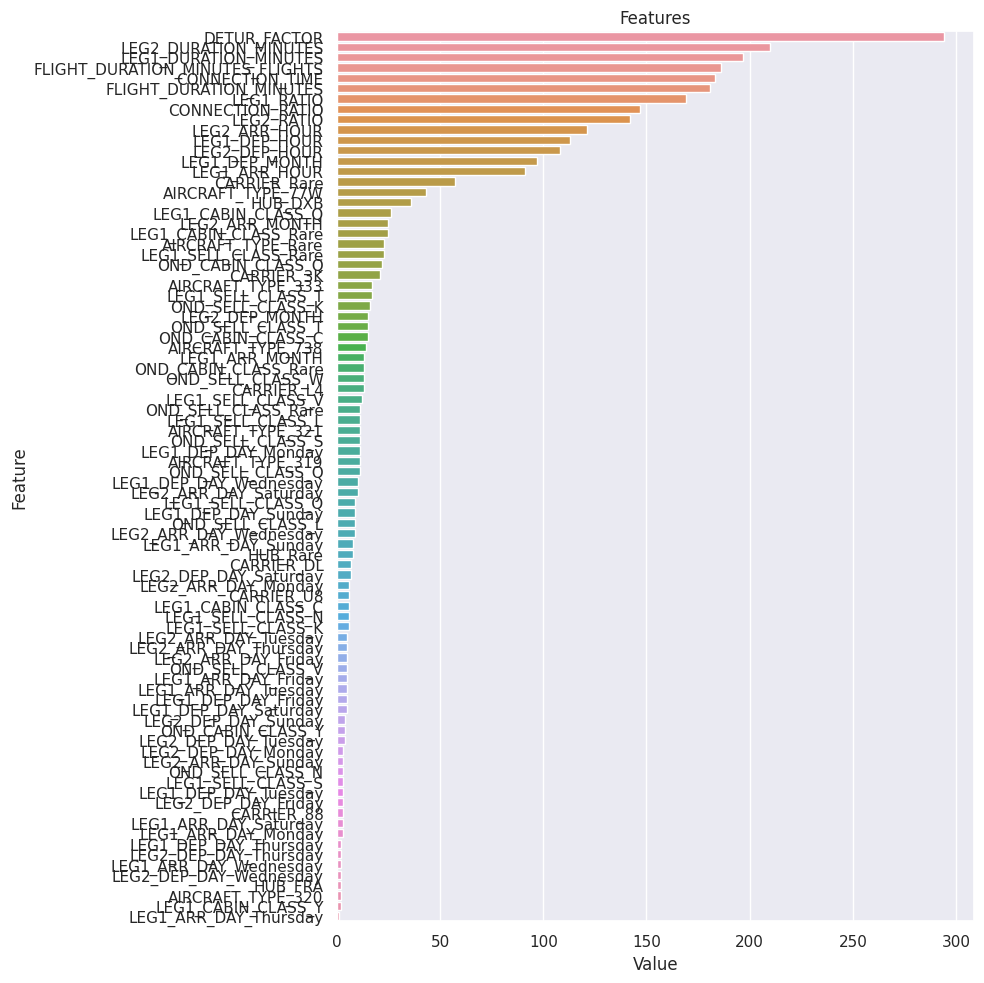

In [ ]:


def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                         ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = LGBMRegressor()
model.fit(X, y)

plot_importance(model, X)